# Customer churn analysis with low-rank tensor block hazard model

Here we present an example for implementing the proposed framework and compared it with two common models, generalized linear model (GLM) and Cox proportional hazard (Cox-PH). A full list of comparison can be found in `sim.py`. 

# Example

In [1]:
from functools import partial
import numpy as np
import pandas as pd
from scipy.special import expit
from utils import theta2prob, gen_data_potential_Y_binary, \
    TensorCompletionCovariateBinary, \
    get_theta_binary, get_theta_survival, \
        regime_eval, regime_prec
import scipy
from sim import main
import matplotlib.pyplot as plt

## Generate data N = 500, T = 10, k =3

In [2]:
N = 500; T = 10; k = 3; d = 3; seed = 2
Y, A, delta, X, theta_true, error = gen_data_potential_Y_binary(seed = seed, N = N, T = T, k = k, d = d)

## Estimate the weight propensities

In [3]:
def weight_contd_grad(coef, XX_t, A_t):
        
        N = XX_t.shape[0]
        X_cov = np.hstack((np.ones((N, 1)), XX_t))
        # compute the weight
        linear_pred = np.dot(X_cov, coef)
        # obj_grad_CAL = (A_t/expit(linear_pred) -1).dot(XX_t)/N
        obj_grad_CAL = (A_t / expit(linear_pred) -1).dot(X_cov)/N
        # obj_grad_CAL = (expit(linear_pred) - A_t).dot(XX_t)/N
        return obj_grad_CAL
def rho_trt(kn):
    weights_coef1 = scipy.optimize.root(fun = partial(weight_contd_grad,
                                      XX_t = X, A_t = A[:, kn]),
                        x0 = np.zeros(d+1),
                        # jac = partial(weight_contd_hess,
                        #               XX_t = CV_X,
                        #               A_t = CV_A),
                        method = 'linearmixing').x
    weights_coef0 = scipy.optimize.root(fun = partial(weight_contd_grad,
                                      XX_t = X, A_t = 1 - A[:, kn]),
                        x0 = np.zeros(d+1),
                        # jac = partial(weight_contd_hess,
                        #               XX_t = CV_X,
                        #               A_t = CV_A),
                        method = 'linearmixing').x
    # compute the estimated propensity weights
    rho = expit(X @ weights_coef1[1:] + weights_coef1[0]) * A[:, kn] +\
        expit(X @ weights_coef0[1:] + weights_coef0[0]) * (1-A[:, kn]) 
    return rho
    
# focus on past k treatments
PS_trt = np.array([rho_trt(kn) for kn in range(k)]) 
rho = np.apply_along_axis(np.prod, 0, PS_trt)

## Low-rank tensor block hazard model estimation

In [4]:
# replace Nan with zero for computational purpose
Y[np.isnan(Y)]= 0    
# weighted tensor block hazard model
TC_bry_w = TensorCompletionCovariateBinary(Y = Y, A = A, X = X, delta = delta,
                                           rho = rho,
                                           stepsize = 1e-4,     
                                           niters = 10000,
                                           r1_list = [4], r2_list = [2], r3_list = [k + 1])
theta_hat_w = TC_bry_w.SequentialTuning() # it take around 2-3 minutes

C:\Users\chyga\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(CO-Tucker): 0th iteration with loss: 11.304
(CO-Tucker): 1000th iteration with loss: 9.527
(CO-Tucker): 2000th iteration with loss: 9.523
(CO-Tucker): 3000th iteration with loss: 9.519
(CO-Tucker): 4000th iteration with loss: 9.515
(CO-Tucker): 5000th iteration with loss: 9.51
(CO-Tucker): 6000th iteration with loss: 9.505
(CO-Tucker): 7000th iteration with loss: 9.499
(CO-Tucker): 8000th iteration with loss: 9.493
(CO-Tucker): 9000th iteration with loss: 9.485


Next, we compare the normalized tensor mean squared error, $\|\widehat{\mathcal{Y}}-\mathcal{Y}^*\|/\|\mathcal{Y}^*\|$, yielded by our proposal with two other benchmarks, GLM and Cox-PH, to showcase its **superority**. The full list of comparisons can be found in `sim.py` and our main paper.

In [5]:
# obtain the estimated survival curves of generalized linear model
est_prob_GLM = theta2prob(get_theta_binary(Y = Y, A = A, X = X, delta = delta,
                                          method = 'logit'))
# obtain the estimated survival curves of CoxPh model
est_prob_CoxPH = get_theta_survival(Y, A, X, delta, method = 'coxPH')
# obtain the estimated survival curves of our model
est_prob_TC = theta2prob(theta_hat_w)
# true survival curves
true_prob = theta2prob(theta_true)
# output the normalized tensor estimation error
print('Normalized tensor estimation error of GLM: {0:.4f}\n'.format(np.linalg.norm(est_prob_GLM - true_prob)/\
    np.linalg.norm(true_prob)))
print('Normalized tensor estimation error of CoxPH: {0:.4f}\n'.format(np.linalg.norm(est_prob_CoxPH - true_prob)/\
    np.linalg.norm(true_prob)))
print('Normalized tensor estimation error of ours: {0:.4f}\n'.format(np.linalg.norm(est_prob_TC - true_prob)/\
    np.linalg.norm(true_prob)))

Normalized tensor estimation error of GLM: 0.5791

Normalized tensor estimation error of CoxPH: 0.6063

Normalized tensor estimation error of ours: 0.2256



## Output the survival curves

As we have completed the parameter tensor, we can now compute the individualized survival curves (or the churn probabilities) under any treatment $a$; see below for an example for one selected customer.

Text(0.5, 0, 'Time')

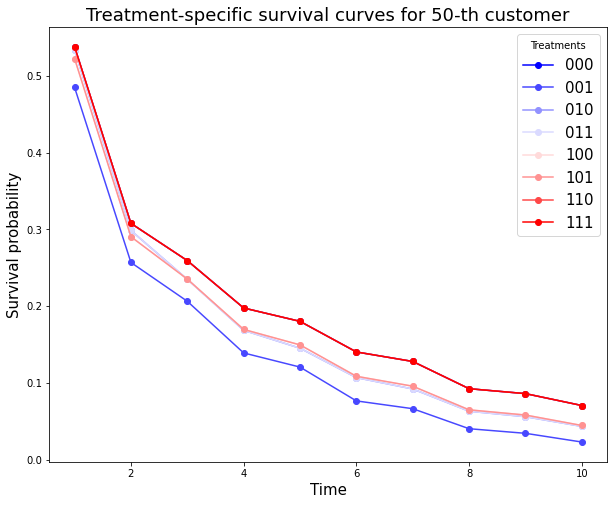

In [6]:
# plot individualized survival curves for i-th customer
i = 50;  
cmap = plt.get_cmap('bwr')
colors = [cmap(i) for i in np.linspace(0, 1, 2**k)]
fig, ax = plt.subplots(figsize=(10, 8))
for l, color in enumerate(colors):
    ax.plot(range(1,T+1), 
             est_prob_TC[i-1, :, l-1], '-o',
             color=color, label= f'{(bin(l)[2:]).zfill(3)}')
ax.legend(loc='best', fontsize=15, title='Treatments')
ax.set_title(f'Treatment-specific survival curves for {i}-th customer', fontsize= 18)
ax.set_ylabel('Survival probability', fontsize=15)
ax.set_xlabel('Time', fontsize=15)

In addition, we can obtain and plot the treatment-specific survival curves for the population by averaging over all the customers. The results suggest that the more active treatments one receives, the higher the survival probabilities will be. This aligns with our data generation process of $\theta_{i,t,l}$, which includes the number of active treatments $\mathrm{cum}\{(l)_{2}\}$ as a latent factor.

Text(0.5, 0, 'Time')

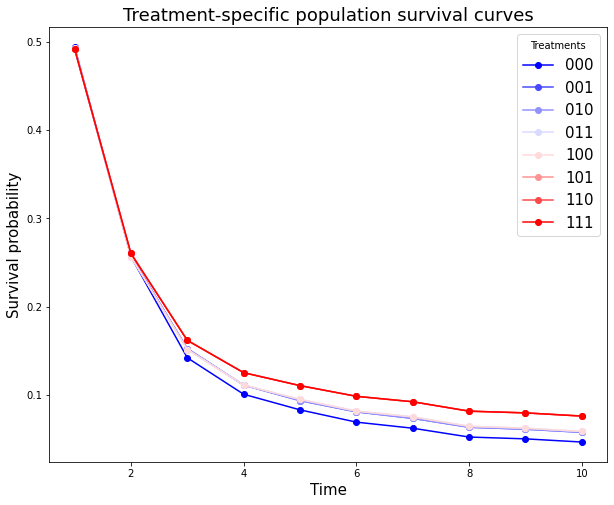

In [7]:
# plot population survival curves
prob_survival_avg = est_prob_TC.mean(axis = 0)
cmap = plt.get_cmap('bwr')
colors = [cmap(i) for i in np.linspace(0, 1, 2**k)]
fig, ax = plt.subplots(figsize=(10, 8))
for i, color in enumerate(colors):
    ax.plot(range(1,T+1), 
             prob_survival_avg[:, i], '-o',
             color=color, label= f'{(bin(i)[2:]).zfill(3)}')
ax.legend(loc='best', fontsize=15, title='Treatments')
ax.set_title(f'Treatment-specific population survival curves', fontsize= 18)
ax.set_ylabel('Survival probability', fontsize=15)
ax.set_xlabel('Time', fontsize=15)